0. Saving concatenated parquet files into DataFrame

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

concatenatedfile_path=os.path.join("..", "data", "processed","concatenated_data")
image_dir = os.path.join("..", "reports","figures", "plot_image")

event=pd.read_parquet(f'{concatenatedfile_path}/event_concatenated.parquet')
away_team=pd.read_parquet(f'{concatenatedfile_path}/away_team_concatenated.parquet')
away_team_score=pd.read_parquet(f'{concatenatedfile_path}/away_team_score_concatenated.parquet')
home_team=pd.read_parquet(f'{concatenatedfile_path}/home_team_concatenated.parquet')
home_team_score=pd.read_parquet(f'{concatenatedfile_path}/home_team_score_concatenated.parquet')
odds=pd.read_parquet(f'{concatenatedfile_path}/odds_concatenated.parquet')
pbp=pd.read_parquet(f'{concatenatedfile_path}/pbp_concatenated.parquet')
power=pd.read_parquet(f'{concatenatedfile_path}/power_concatenated.parquet')
round=pd.read_parquet(f'{concatenatedfile_path}/round_concatenated.parquet')
season=pd.read_parquet(f'{concatenatedfile_path}/season_concatenated.parquet')
statistics=pd.read_parquet(f'{concatenatedfile_path}/statistics_concatenated.parquet')
time=pd.read_parquet(f'{concatenatedfile_path}/time_concatenated.parquet')
tournament=pd.read_parquet(f'{concatenatedfile_path}/tournament_concatenated.parquet')
venue=pd.read_parquet(f'{concatenatedfile_path}/venue_concatenated.parquet')
votes=pd.read_parquet(f'{concatenatedfile_path}/votes_concatenated.parquet')


0. Function to determine winner code of each match based on point by point records

In [26]:
def determine_winner_code_basedon_pbp():
    unique_matchids = pd.Series(pbp['match_id'].unique())
    results = []
    
    # Iterate over each unique match ID
    for match in unique_matchids:
        my_match = pbp[pbp['match_id'] == match]
        max_home_score = my_match['home_score'].max()
        max_away_score= my_match['away_score'].max()
        if max_home_score > max_away_score:
            winner = 'home'  # Home team wins
        else:
            winner = 'away'  # Away team wins

        # Append the match ID and winner to the results list
        results.append({'match_id': match, 'winner': winner})

    # Create a DataFrame from the results list
    winner_df = pd.DataFrame(results)
    return winner_df

winnercode_df=determine_winner_code_basedon_pbp()

In [27]:
home_winners = winnercode_df[winnercode_df['winner'] == 'home'].merge(home_team[['match_id','player_id','full_name']], on='match_id', how='inner').drop_duplicates()
away_winners = winnercode_df[winnercode_df['winner'] == 'away'].merge(away_team[['match_id','player_id','full_name']], on='match_id', how='inner').drop_duplicates()
all_winners=pd.concat([home_winners,away_winners])

1. which players from Iran have participated in tennis competitions?

In [2]:
pd.concat([home_team[home_team['country']=='Iran'][['player_id','full_name']],away_team[away_team['country']=='Iran'][['player_id','full_name']]]).drop_duplicates()

,player_id,full_name
951,206924,"Moghimi, Sina"


2. How many players have a career spanning more than 15 years?

The number of players with a career spanning more than 15 years is: 95


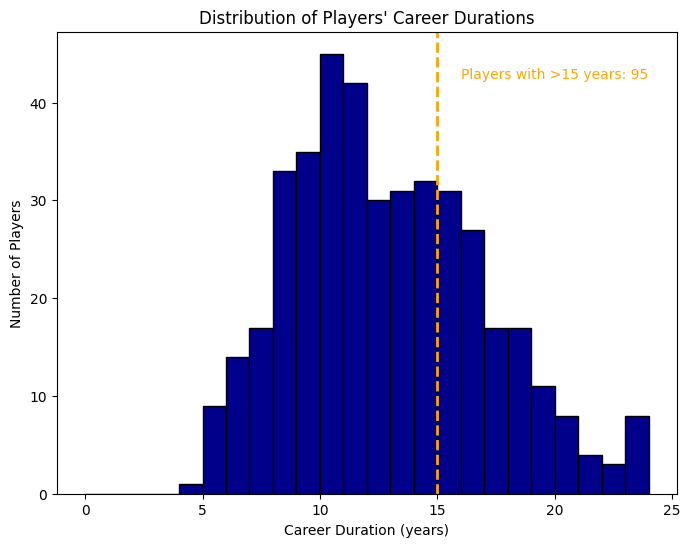

In [44]:
# Combine home and away team data to get player info
player_data = pd.concat([home_team[['player_id', 'turned_pro','Record_date']], away_team[['player_id', 'turned_pro','Record_date']]]).sort_values('Record_date').drop_duplicates(['player_id'],keep='last').dropna(subset=['turned_pro'])
current_year = 2024

# Calculate the career duration for each player
player_data['career_duration'] = current_year - player_data['turned_pro'].astype(int)

# Filter players with a career duration of more than 10 years
players_over_15_years = player_data[player_data['career_duration'] > 15]
num_players_over_15_years = players_over_15_years['player_id'].nunique()

print(f"The number of players with a career spanning more than 15 years is: {num_players_over_15_years}")


# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(player_data['career_duration'], bins=range(0, player_data['career_duration'].max() + 1, 1), color='darkblue', edgecolor='black')

# Highlight the players with more than 15 years of career duration
plt.axvline(x=15, color='orange', linestyle='--', linewidth=2)
plt.text(16, plt.ylim()[1] * 0.9, f'Players with >15 years: {num_players_over_15_years}', color='orange')

# Adding labels and title
plt.xlabel('Career Duration (years)')
plt.ylabel('Number of Players')
plt.title('Distribution of Players\' Career Durations')
save_path = os.path.join(image_dir, 'B2.jpg')
plt.savefig(save_path)
# Show the plot
plt.show()

3. What is the distribution of players' weights in the dataset?

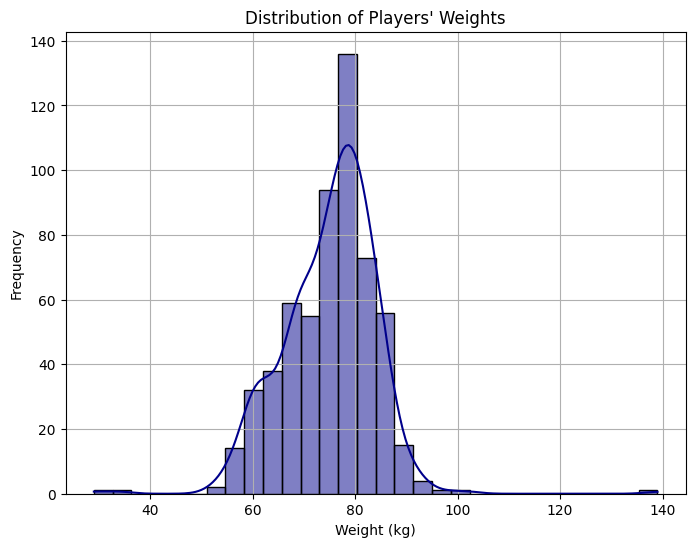

In [45]:
# Combine home and away team data to get player weights
player_weights = pd.concat([home_team[['player_id', 'weight','Record_date']], away_team[['player_id', 'weight','Record_date']]]).sort_values('Record_date').drop_duplicates(['player_id'],keep='last').dropna()

# Convert weights to numeric (if they are not already)
player_weights['weight'] = pd.to_numeric(player_weights['weight'], errors='coerce')

# Drop any rows that couldn't be converted to numeric
player_weights = player_weights.dropna(subset=['weight'])

# Plot the distribution of players' weights
plt.figure(figsize=(8, 6))
sns.histplot(player_weights['weight'], bins=30, kde=True,color='darkblue')
plt.title('Distribution of Players\' Weights')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.grid(True)
save_path = os.path.join(image_dir, 'B3.jpg')
plt.savefig(save_path)
plt.show()


4. Which tournament has the highest number of participating players?

In [46]:
# Combine home and away team data to get player and tournament information
home_team_tournament = home_team[['match_id', 'player_id']].merge(tournament[['match_id', 'tournament_id']], on='match_id')
away_team_tournament = away_team[['match_id', 'player_id']].merge(tournament[['match_id', 'tournament_id']], on='match_id')

# Concatenate home and away data
all_players_tournaments = pd.concat([home_team_tournament, away_team_tournament]).drop_duplicates()

# Count the number of unique players for each tournament
tournament_player_counts = all_players_tournaments.groupby('tournament_id')['player_id'].nunique().reset_index(name='player_count')

# Find the tournament with the highest number of participating players
tournament_with_max_players = tournament_player_counts.loc[tournament_player_counts['player_count'].idxmax()]

# Get the name of the tournament
tournament_name = tournament.loc[tournament['tournament_id'] == tournament_with_max_players['tournament_id'], 'tournament_name'].values[0]
print(f"The tournament with the highest number of participating players is {tournament_name} with {tournament_with_max_players['player_count']} players.")

The tournament with the highest number of participating players is French Open, Paris, France with 130 players.


5. How many matches have been decided by a tie-break?

In [50]:
match_scores=pd.concat([home_team_score,away_team_score]).sort_values('Record_date').drop_duplicates(keep='last')

# Check if there is a tie-break in any of the periods
match_scores['tie_break'] = match_scores[['period_1_tie_break', 'period_2_tie_break', 'period_3_tie_break', 'period_4_tie_break', 'period_5_tie_break']].sum(axis=1) > 0

# Count the number of matches decided by a tie-break
matches_with_tie_break = match_scores[match_scores['tie_break']].drop_duplicates(['match_id']).shape[0]
print(f"The number of matches decided by a tie-break is: {matches_with_tie_break}")


The number of matches decided by a tie-break is: 1413


6. What is the average number of games per match?

The average number of games per match is: 10.29


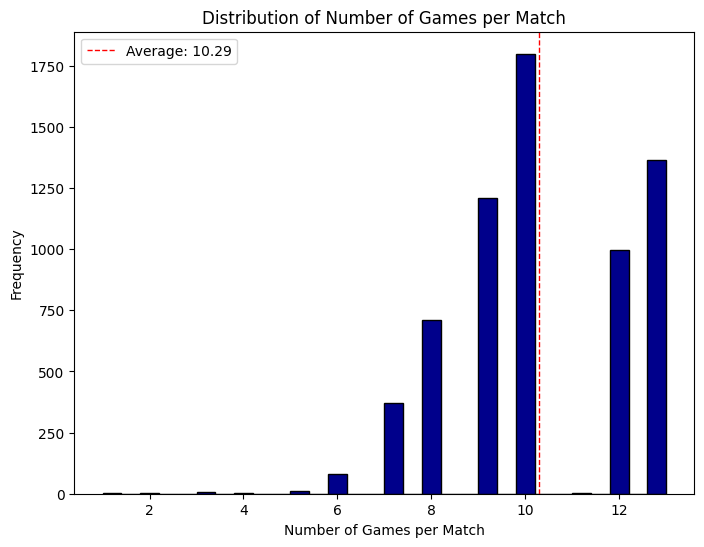

In [54]:
# Calculate the number of games in each match
unique_pbp=pbp.sort_values('Record_date').drop_duplicates(['match_id','set_id','game_id'],keep='last')
games_per_match = unique_pbp.groupby('match_id')['game_id'].nunique().reset_index(name='game_count')

# Calculate the average number of games per match
average_games_per_match = games_per_match['game_count'].mean()

print(f"The average number of games per match is: {average_games_per_match:.2f}")

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(games_per_match['game_count'], bins=30, color='darkblue', edgecolor='black')
plt.axvline(average_games_per_match, color='red', linestyle='dashed', linewidth=1, label=f'Average: {average_games_per_match:.2f}')
plt.xlabel('Number of Games per Match')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Games per Match')
plt.legend()
save_path = os.path.join(image_dir, 'B6.jpg')
plt.savefig(save_path)
plt.show()

7. Which player has the most double faults in a single match?

In [58]:
# Filter for double faults data
double_faults_data = statistics[(statistics['period'] == 'ALL') & (statistics['statistic_name'] == 'double_faults')]
double_faults_data=double_faults_data.sort_values('Record_date').drop_duplicates(['match_id', 'period'],keep='last')

# Merge double faults data with home and away team player information
home_double_faults = double_faults_data[['match_id', 'home_stat']].merge(home_team[['match_id', 'player_id', 'full_name']], on='match_id')
away_double_faults = double_faults_data[['match_id', 'away_stat']].merge(away_team[['match_id', 'player_id', 'full_name']], on='match_id')

# Rename columns for clarity
home_double_faults.rename(columns={'home_stat': 'double_faults'}, inplace=True)
away_double_faults.rename(columns={'away_stat': 'double_faults'}, inplace=True)

# Combine home and away double faults data
all_double_faults = pd.concat([home_double_faults[['match_id', 'player_id', 'full_name', 'double_faults']], 
                               away_double_faults[['match_id', 'player_id', 'full_name', 'double_faults']]])

# Find the player with the most double faults in a single match
max_double_faults = all_double_faults.loc[all_double_faults['double_faults'].idxmax()]
print(f"The player with the most double faults in a single match is {max_double_faults['full_name']}")

The player with the most double faults in a single match is 48    Braynin, Aleksandr
48         Sherif, Mayar
Name: full_name, dtype: object


8. Which cities have hosted the most tennis matches?

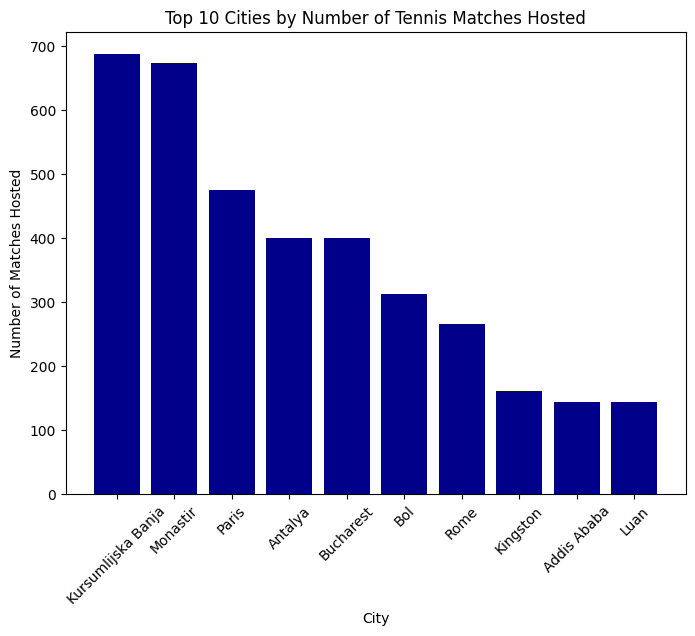

In [61]:
# Extract venue for competitions
venue_city = venue[['match_id', 'city']].drop_duplicates()

# Count the occurrences of each unique city
city_count = venue_city['city'].value_counts().reset_index()
city_count.columns = ['city', 'count']

# Display the top 10 cities that have hosted the most tennis matches
top_10_cities = city_count.head(10)

plt.figure(figsize=(8, 6))
plt.bar(top_10_cities['city'], top_10_cities['count'], color='darkblue')
plt.xlabel('City')
plt.ylabel('Number of Matches Hosted')
plt.title('Top 10 Cities by Number of Tennis Matches Hosted')
plt.xticks(rotation=45)
save_path = os.path.join(image_dir, 'B8.jpg')
plt.savefig(save_path)
plt.show()